In [31]:
from data_utils import *

# Example

## Loading data

In [2]:
h5_dir = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\raw'
simu_id = 5
simu_name = f'simu{simu_id:05d}'
P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
P.grid_zlims

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\raw\simus_00001-01000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Beamforming

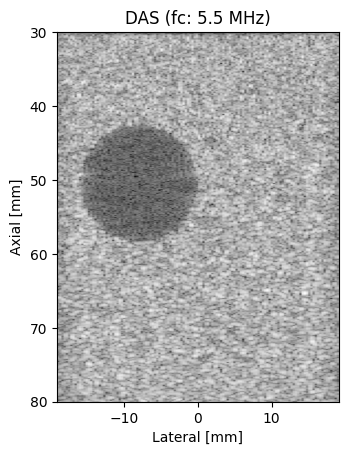

In [11]:
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[1], num=800)
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[1], num=128)
grid = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)
bmode_DAS, _ = make_bimg_das1(copy.deepcopy(P), grid, device='cpu')


extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
ax.imshow(bmode_DAS, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
ax.set_xlabel('Lateral [mm]')
ax.set_ylabel('Axial [mm]')
ax.set_title('DAS (fc: %.1f MHz)' % (P.fc/1e6))
plt.show()

## Computing metrics

In [12]:
from metrics import compute_metrics

In [13]:
P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
contrast_img, cnr_img, snr_img, gcnr_img = compute_metrics(P.pos_lat,P.pos_ax,P.radius, bmode_DAS, grid)
print(contrast_img, cnr_img, snr_img, gcnr_img)

-16.882545948028564 -1.2732946 0.8629634239643112 1.4957354


# Metrics for testing set

## Params in testing set

In [91]:
import os
testing_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
input_file_list = sorted(os.listdir(testing_folder))
print(input_file_list[-1][:-4])
int(input_file_list[-1][-9:-4])

simu12496


12496

In [24]:
import pandas as pd
import pickle
P = LoadDataParams(h5_dir=h5_dir, simu_name=f'simu00001')
with open("common_params.pkl", "wb") as f:
    pickle.dump(P, f)

In [31]:
r = []
cx = []
cz = []
c = []
ids = []
for file in input_file_list:
    P = LoadDataParams(h5_dir=h5_dir, simu_name=file[:-4])
    r.append(P.radius)
    c.append(P.c)
    cx.append(P.pos_lat)
    cz.append(P.pos_ax)
    ids.append(int(file[-9:-4]))
dataset_params = {"id": ids, "r": r, "cx": cx, "cz": cz, "c": c}
params_df = pd.DataFrame(dataset_params)
params_df.to_csv('dataset_params.csv')

In [32]:
params_df.head()

,id,r,cx,cz,c
0,14,0.008,-0.006,0.0550,1420.0
1,15,0.006,-0.008,0.0575,1570.0
2,16,0.006,-0.008,0.0475,1480.0
3,21,0.006,0.012,0.0600,1590.0
4,24,0.002,-0.004,0.0575,1420.0


## Computing images from model

In [78]:
from guided_diffusion import *
from torch.utils.data import DataLoader
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
input_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\target_enh'

In [79]:
data = CustomDataset(input_folder, output_folder, transform=True)
BATCH_SIZE = 32
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
x_sample,y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
print(x_sample.shape)
data.input_file_list[:4]

torch.Size([32, 2, 800, 128])


['simu00014.npy', 'simu00015.npy', 'simu00016.npy', 'simu00021.npy']

In [80]:
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v10_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))

<All keys matched successfully>

In [81]:
# NOISE SCHEDULE
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

In [82]:
y_gen, intermediate = sample_image_cond(x_sample, model, beta, num_intermediate=1)

100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


In [88]:
import numpy as np
from pathlib import Path
gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated')
batch_number = 0
for id, sample in enumerate(y_gen):
    name = (data.input_file_list[batch_number*BATCH_SIZE + id])
    np.save(gen_folder/name, sample.cpu().detach().numpy())

In [95]:
batch_number = 35
input_file_list[batch_number * BATCH_SIZE + 0]

'simu05675.npy'

In [ ]:
batch_number = 0
for x, y in dataloader:  # x: images
    x = x.to(device)
    if batch_number >= 36:
        y_gen, intermediate = sample_image_cond(x, model, beta, num_intermediate=1)
        print(f'Saving batch {batch_number}')
        for id, sample in enumerate(y_gen):
            name = (data.input_file_list[batch_number * BATCH_SIZE + id])
            np.save(gen_folder / name, sample.cpu().detach().numpy())
    batch_number += 1

100%|██████████| 1000/1000 [06:45<00:00,  2.46it/s]


Saving batch 36


100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


Saving batch 37


100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


Saving batch 38


100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


Saving batch 39


100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


Saving batch 40


100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


Saving batch 41


100%|██████████| 1000/1000 [06:42<00:00,  2.49it/s]


Saving batch 42


100%|██████████| 1000/1000 [06:42<00:00,  2.48it/s]


Saving batch 43


100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


Saving batch 44


100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


Saving batch 45


100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


Saving batch 46


 71%|███████   | 712/1000 [04:36<02:04,  2.31it/s]

## Computing metrics

In [10]:
import os
import pandas as pd
df = pd.read_csv('testing_params.csv')
df.head()

,id,r,cx,cz,c
0,14,0.008,-0.006,0.0550,1420.0
1,15,0.006,-0.008,0.0575,1570.0
2,16,0.006,-0.008,0.0475,1480.0
3,21,0.006,0.012,0.0600,1590.0
4,24,0.002,-0.004,0.0575,1420.0


In [14]:
from compute_metrics import *
import pickle
from pathlib import Path
gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated')
testing_file_list = os.listdir(gen_folder)

with open('common_params.pkl','rb') as f:
    P = pickle.load(f)
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[1], num=800)
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[1], num=128)
grid = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)

simu05694.npy


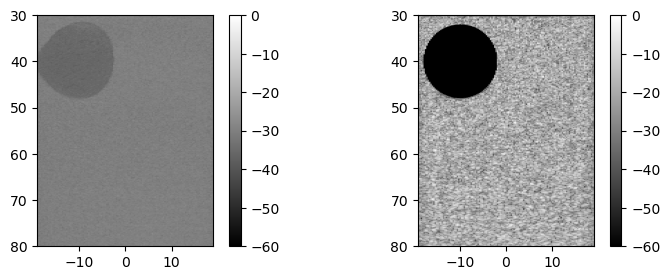

In [99]:
from matplotlib import pyplot as plt

file = input_file_list[35 * BATCH_SIZE+ 5]
print(file)
bmode_output = np.load(gen_folder / file).squeeze()
bmode_output = (bmode_output + 1) * 30 - 60

target_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\target_enh')
target = np.load(target_folder / file)
target = (target * 60) - 60

extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.show()


In [17]:
from metrics import compute_metrics
for id, file in enumerate(testing_file_list):
    bmode_output = np.load(gen_folder/file).squeeze()
    bmode_output = (bmode_output + 1) * 30 - 60
    cx = df.loc[id, "cx"]
    cz = df.loc[id, "cz"]
    r = df.loc[id, "r"]
    contrast, cnr, gcnr, snr = compute_metrics(cx, cz, r, bmode_output, grid)    
    df.loc[id, "contrast"] = contrast
    df.loc[id, "cnr"] = cnr
    df.loc[id, "snr"] = snr
    df.loc[id, "gcnr"] = gcnr
df.to_csv('diffusion_metrics.csv')
df.head()

,id,r,cx,cz,c,contrast,cnr,snr,gcnr
0,14,0.008,-0.006,0.0550,1420.0,0.118807,0.028371,2.860323,0.086577
1,15,0.006,-0.008,0.0575,1570.0,1.121084,0.476441,3.876218,0.248791
2,16,0.006,-0.008,0.0475,1480.0,-0.052396,-0.034924,8.297807,0.122643
3,21,0.006,0.012,0.0600,1590.0,0.235235,0.106764,5.086346,0.140765
4,24,0.002,-0.004,0.0575,1420.0,0.124575,0.092673,8.639487,0.524997


In [19]:
das_folder = Path(r'F:\simulatedCystDataset\das_full')
for id, file in enumerate(testing_file_list):
    bmode = np.load(das_folder / file)
    bmode = (bmode * 60) - 60
    cx = df.loc[id, "cx"]
    cz = df.loc[id, "cz"]
    r = df.loc[id, "r"]
    contrast, cnr, gcnr, snr = compute_metrics(cx, cz, r, bmode, grid)
    df.loc[id, "contrast"] = contrast
    df.loc[id, "cnr"] = cnr
    df.loc[id, "snr"] = snr
    df.loc[id, "gcnr"] = gcnr
df.to_csv('das_metrics.csv')
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\simulatedCystDataset\\das_full\\simu00014.npy'

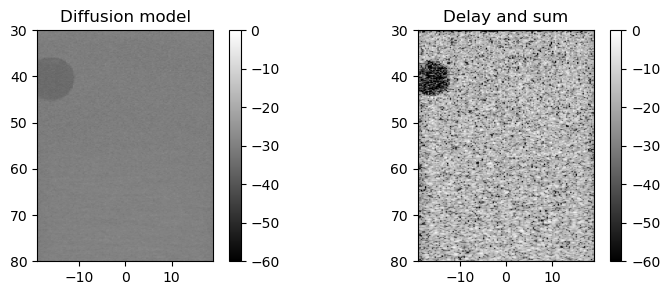

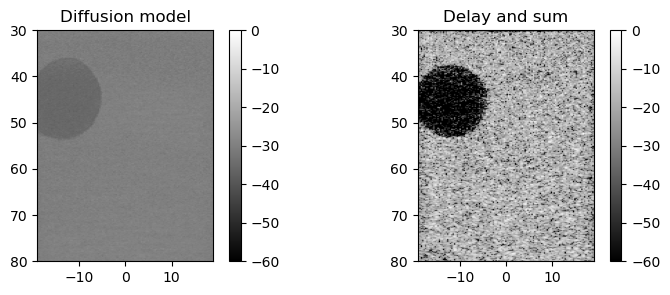

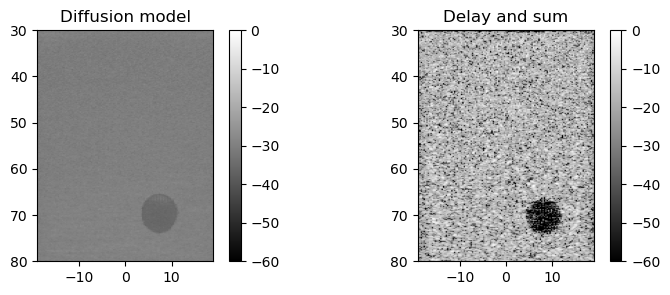

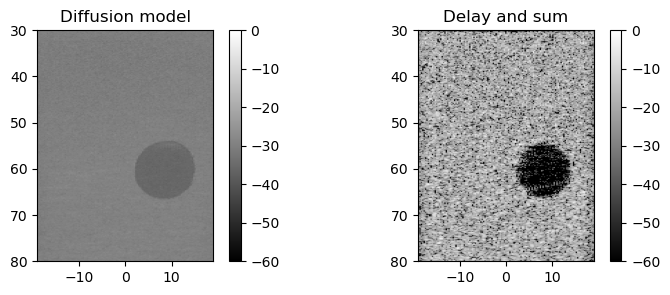

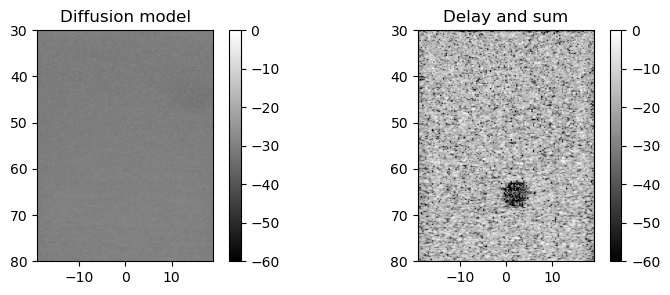

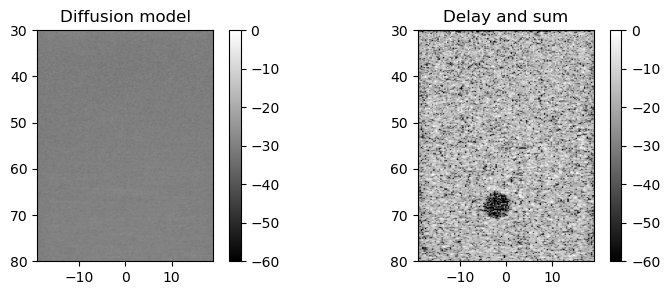

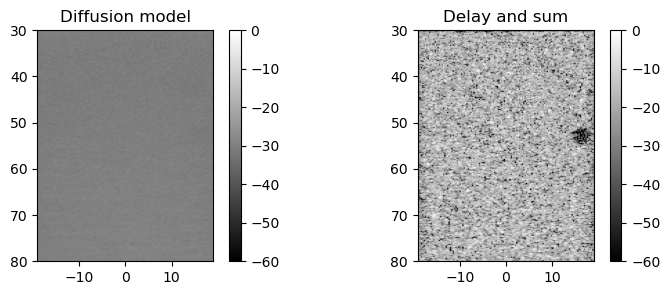

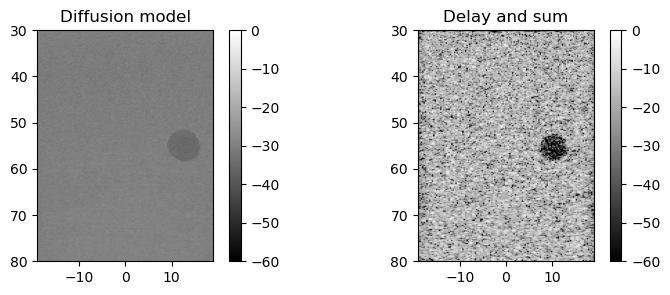

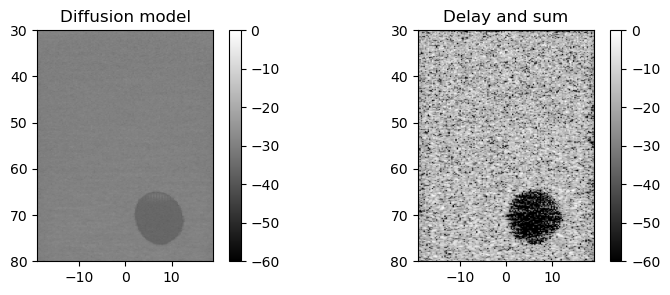

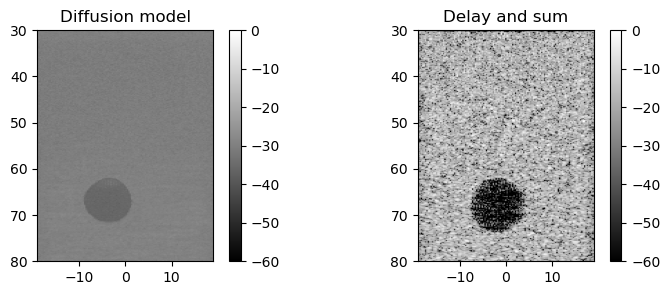

In [77]:
from matplotlib import pyplot as plt
gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated')
das_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\das_full')
testing_file_list = os.listdir(gen_folder)

for file in testing_file_list[40:50]:
    bmode_output = np.load(gen_folder / file).squeeze()
    bmode_output = (bmode_output + 1) * 30 - 60

    target = np.load(das_folder / file)
    target = (target * 60) - 60

    extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
    plt.colorbar()
    plt.title('Diffusion model')

    plt.subplot(1, 2, 2)
    plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
    plt.colorbar()
    plt.title('Delay and sum')

    plt.show()

# Comparing results

In [38]:
import seaborn as sns
import pandas as pd
df_das = pd.read_csv('das_metrics.csv')
df_diff = pd.read_csv('diffusion_metrics.csv')

In [39]:
df_das['r'] = df_das['r']*1000
df_diff['r'] = df_diff['r']*1000

In [40]:
df_das['cnr'] = abs(df_das['cnr'])
df_diff['cnr'] = abs(df_diff['cnr'])

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\3681270775.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS','_','Diff'])


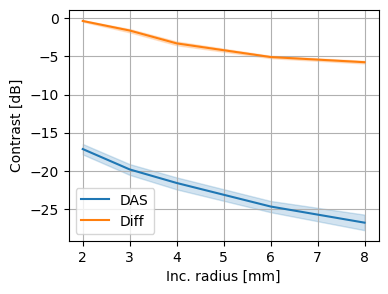

In [50]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='contrast')
sns.lineplot(data=df_diff, x='r', y='contrast')
plt.ylabel('Contrast [dB]')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS','_','Diff'])
plt.grid()
plt.show()

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\1747426968.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


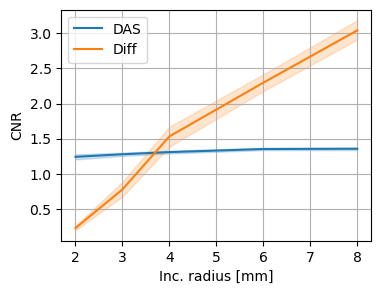

In [52]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='cnr')
sns.lineplot(data=df_diff, x='r', y='cnr')
plt.ylabel('CNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\3083733976.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


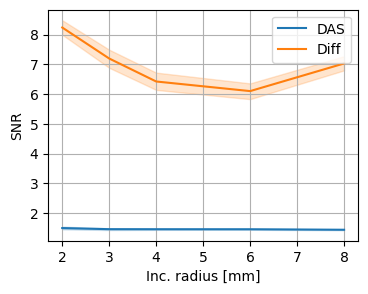

In [53]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='snr')
sns.lineplot(data=df_diff, x='r', y='snr')
plt.ylabel('SNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()


C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\2262025728.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


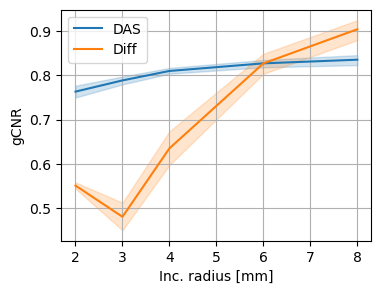

In [55]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='gcnr')
sns.lineplot(data=df_diff, x='r', y='gcnr')
plt.ylabel('gCNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()


### SoS

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\1045109059.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


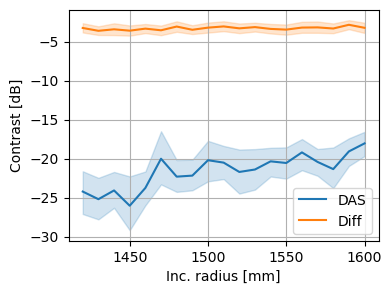

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\1045109059.py:14: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


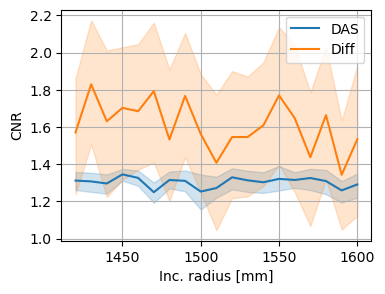

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\1045109059.py:22: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


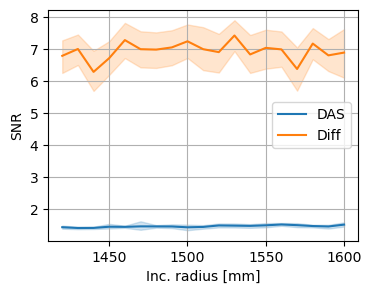

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_24268\1045109059.py:31: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


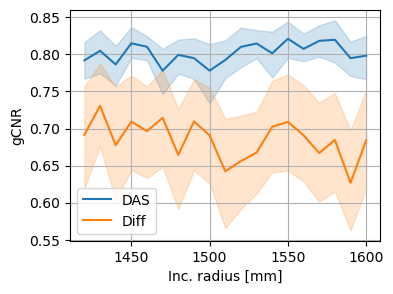

In [56]:
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='contrast')
sns.lineplot(data=df_diff, x='c', y='contrast')
plt.ylabel('Contrast [dB]')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='cnr')
sns.lineplot(data=df_diff, x='c', y='cnr')
plt.ylabel('CNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='snr')
sns.lineplot(data=df_diff, x='c', y='snr')
plt.ylabel('SNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()

plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='gcnr')
sns.lineplot(data=df_diff, x='c', y='gcnr')
plt.ylabel('gCNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()


In [58]:
df_diff.mean()

Unnamed: 0    1249.500000
id            6307.467600
r                4.598000
cx               0.000018
cz               0.054521
c             1509.028000
contrast        -3.299940
cnr              1.613846
snr              6.969274
gcnr             0.685430
dtype: float64

In [59]:
df_das.mean()


Unnamed: 0    1249.500000
id            6307.467600
r                4.598000
cx               0.000018
cz               0.054521
c             1509.028000
contrast       -21.639745
cnr              1.302674
snr              1.469926
gcnr             0.801599
dtype: float64